In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import matplotlib.cbook as cbook
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
path = r'/content/gdrive/MyDrive/bus' # use your path
all_files = glob.glob(path + "/*.csv")

In [ ]:
#Taking the last 3 session files as the TEST dataset
all_files.sort()
all_files_train = all_files[:-5]
all_files_test = all_files[-5:]

In [ ]:
# Train Dataset
li_train = []
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame_train = pd.concat(li_train, axis=0, ignore_index=True)
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame_train.columns

Index(['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4',
       'NRxRSRP-0', 'NRxRSRP-1', 'NRxRSRP-2', 'NRxRSRP-3', 'NRxRSRP-4',
       'NRxRSRQ-0', 'NRxRSRQ-1', 'NRxRSRQ-2', 'NRxRSRQ-3', 'NRxRSRQ-4',
       'RSRP-0', 'RSRP-1', 'RSRP-2', 'RSRP-3', 'RSRP-4', 'RSRQ-0', 'RSRQ-1',
       'RSRQ-2', 'RSRQ-3', 'RSRQ-4', 'RSSI-0', 'RSSI-1', 'RSSI-2', 'RSSI-3',
       'RSSI-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'UL_bitrate-0',
       'UL_bitrate-1', 'UL_bitrate-2', 'UL_bitrate-3', 'UL_bitrate-4',
       'DL_bitrate'],
      dtype='object')

In [ ]:
# Test Dataset
li_test = []
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_test.append(df)
frame_test = pd.concat(li_test, axis=0, ignore_index=True)
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,8,8,8,8,8,3657,5413,7795,7795,6777,...,6.0,6.0,6.0,7.0,162,100,143,143,128,4656
1,8,8,8,8,8,4719,3657,5413,7795,7795,...,4.0,6.0,6.0,6.0,155,162,100,143,143,5294
2,6,8,8,8,8,7280,4719,3657,5413,7795,...,4.0,4.0,6.0,6.0,144,155,162,100,143,6627
3,7,6,8,8,8,3813,7280,4719,3657,5413,...,3.0,4.0,4.0,6.0,70,144,155,162,100,9069
4,7,7,6,8,8,4742,3813,7280,4719,3657,...,3.0,3.0,4.0,4.0,86,70,144,155,162,10859


In [ ]:
frame_train.shape

(8197, 46)

# Dealing with Nan Values

## Train Dataframe

In [ ]:
frame_train.replace('-', np.NaN, inplace = True)
frame_train.isna().sum().sum()

86906

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_train)
frame_train = pd.DataFrame(imputed_dataset,columns = frame_train.columns)
frame_train.isna().sum().sum()

0

In [ ]:
frame_train.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,...,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000,9138.000000
mean,7.925854,7.936167,7.949622,7.960893,7.950858,9069.445174,9078.083279,9087.343839,9095.563909,9106.599146,...,3.762623,3.780740,3.797504,3.788173,169.132414,169.265704,169.400525,169.518056,169.665901,9051.297877
std,2.610959,2.605380,2.603570,2.607649,2.604899,10661.073657,10680.883697,10692.339644,10704.146675,10726.931498,...,7.157904,7.150207,7.136740,7.129028,177.694663,177.909987,178.053777,178.204074,178.430375,10108.879258
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-15.000000,-15.000000,-15.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.000000,6.000000,6.000000,6.000000,1791.750000,1800.000000,1800.000000,1791.750000,1789.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,43.000000,43.000000,43.000000,43.000000,43.000000,2041.000000
50%,7.644233,7.630692,7.604475,7.745178,7.631221,5290.000000,5295.500000,5301.000000,5301.000000,5302.500000,...,3.000000,3.000000,3.000000,3.000000,111.500000,112.000000,112.000000,112.000000,112.000000,5619.500000
75%,9.000000,9.019074,9.092670,9.093478,9.104012,12545.250000,12548.000000,12559.000000,12559.000000,12559.750000,...,8.000000,8.000000,8.000000,8.000000,238.000000,238.750000,239.000000,239.000000,239.000000,12556.500000
max,15.000000,15.000000,15.000000,15.000000,15.000000,87872.000000,87872.000000,87872.000000,87872.000000,87872.000000,...,32.000000,32.000000,32.000000,32.000000,1479.000000,1479.000000,1479.000000,1479.000000,1479.000000,74612.000000


## Test DataFrame

In [ ]:
frame_test.replace('-', np.NaN, inplace = True)
frame_test.isna().sum().sum()

13866

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_test)
frame_test= pd.DataFrame(imputed_dataset,columns = frame_test.columns)
frame_test.isna().sum().sum()

0

In [ ]:
frame_test.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,...,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,8.354107,8.285147,8.240997,8.195437,8.191643,13227.755938,13249.345618,13280.176904,13316.046274,13346.890254,...,5.280765,5.256602,5.210704,5.110619,242.701884,243.058149,243.501638,244.007781,244.407043,13167.873874
std,2.274573,2.245767,2.233453,2.225131,2.224539,12141.256218,12176.956574,12233.468655,12296.876423,12361.784647,...,6.430609,6.413481,6.385479,6.350779,225.668975,226.218890,226.849580,227.515656,228.217507,11219.129052
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-12.000000,-12.000000,-12.000000,-12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
25%,7.000000,7.000000,7.000000,7.000000,7.000000,4473.000000,4462.000000,4451.000000,4451.000000,4428.000000,...,1.000000,1.000000,1.000000,1.000000,85.250000,85.000000,85.000000,85.000000,84.250000,4884.750000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,9545.000000,9551.000000,9551.000000,9556.500000,9556.500000,...,6.000000,6.000000,6.000000,5.830577,184.000000,184.000000,184.000000,184.000000,184.000000,10139.500000
75%,9.499816,9.000000,9.000000,9.000000,9.000000,18295.250000,18343.750000,18370.000000,18417.000000,18447.500000,...,8.453835,8.502555,8.128442,8.000000,324.000000,324.000000,324.000000,324.000000,324.750000,17930.750000
max,15.000000,15.000000,15.000000,15.000000,15.000000,86977.000000,86977.000000,86977.000000,86977.000000,86977.000000,...,24.000000,24.000000,24.000000,24.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,75533.000000


# With Scaling

In [ ]:
col_names_scaled = ['DL_bitrate-0', 	'DL_bitrate-1', 	'DL_bitrate-2', 	'DL_bitrate-3', 	'DL_bitrate-4', 'DL_bitrate']

## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:5], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (5737, 5)
Validation set shape (2460, 5)


,0,1,2,3,4
6243,0.105893,0.139487,0.108180,0.152472,0.049128
5786,0.043267,0.066688,0.038181,0.052429,0.059052
5194,0.025071,0.018072,0.024809,0.030920,0.047342
5084,0.070261,0.093693,0.075849,0.060577,0.077510
7919,0.279111,0.258364,0.245129,0.372530,0.325439


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (5737, 5, 1)
Validation set shape (2460, 5, 1)


### Stacked LSTM

In [ ]:
# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# summary of the model  
model.summary()
# use early stop to avoid over-fiting 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 150)            91200     
                                                                 
 dropout_3 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 150)            180600    
                                                                 
 lstm_2 (LSTM)               (None, 5, 150)            180600    
                                                                 
 dropout_4 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_5 (Dropout)         (None, 100)              

In [ ]:
lstm_train_pred_min_max_scaled = model.predict(X_train_min_max_scaler)
lstm_valid_pred_min_max_scaled = model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, lstm_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, lstm_valid_pred_min_max_scaled)))

Train rmse: 0.05952616346335
Validation rmse: 0.06049525181622006


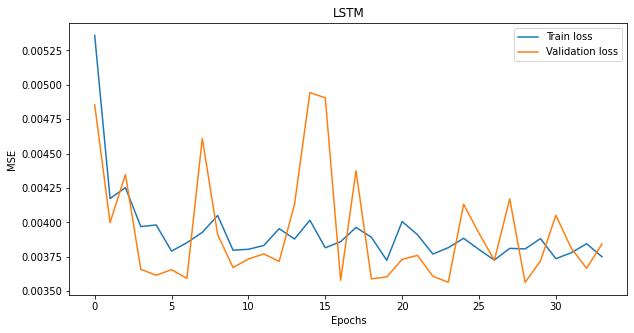

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(history.history['loss'], label='Train loss')
ax3.plot(history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')
plt.show()

In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4
0,0.042046,0.062235,0.089621,0.089621,0.077917
1,0.054256,0.042046,0.062235,0.089621,0.089621
2,0.083700,0.054256,0.042046,0.062235,0.089621
3,0.043839,0.083700,0.054256,0.042046,0.062235
4,0.054520,0.043839,0.083700,0.054256,0.042046


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

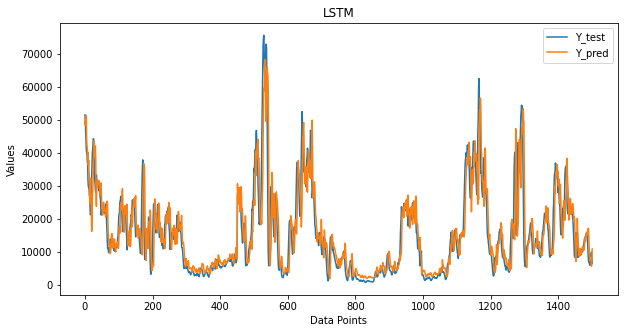

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

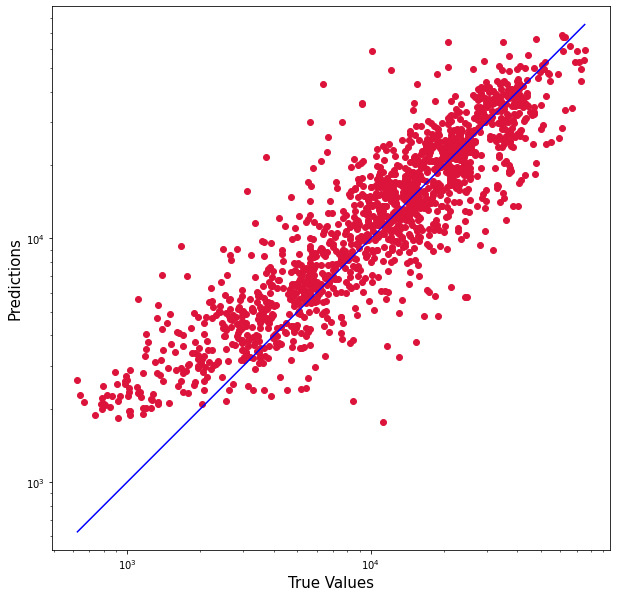

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[5], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[5]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[5]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

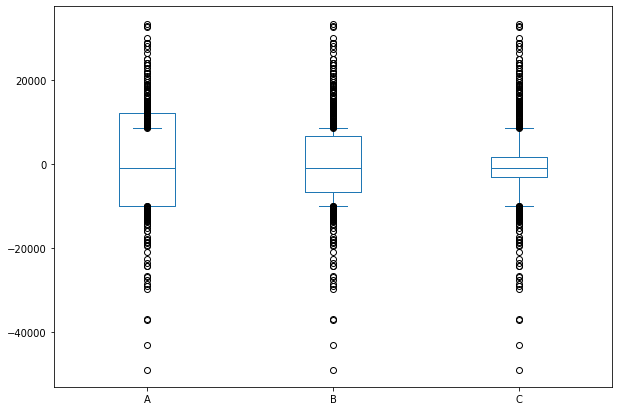

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 4450.044694202317


# Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units1, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.4,default=0.25,step=0.05)))
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=mae,metrics=[mae])

  return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_error',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
tuner.search(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler), epochs=100, callbacks=[monitor])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 254 Complete [00h 00m 31s]
val_mean_absolute_error: 0.033501870930194855

Best val_mean_absolute_error So Far: 0.033421590924263
Total elapsed time: 00h 26m 45s


In [ ]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 512
units2 512
units3 384
learning_rate 0.0001


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train_min_max_series.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 512)               3072      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 384)               196992    
                                                                 
 dropout_2 (Dropout)         (None, 384)               0

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.058011820996710664
Validation rmse: 0.05962197157459976


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4
0,0.042046,0.062235,0.089621,0.089621,0.077917
1,0.054256,0.042046,0.062235,0.089621,0.089621
2,0.083700,0.054256,0.042046,0.062235,0.089621
3,0.043839,0.083700,0.054256,0.042046,0.062235
4,0.054520,0.043839,0.083700,0.054256,0.042046


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

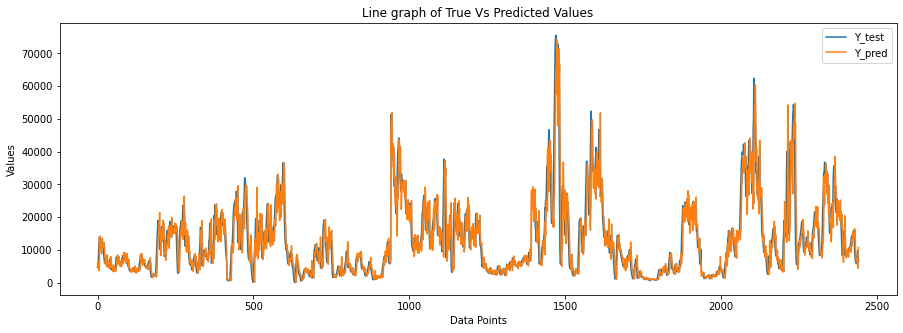

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

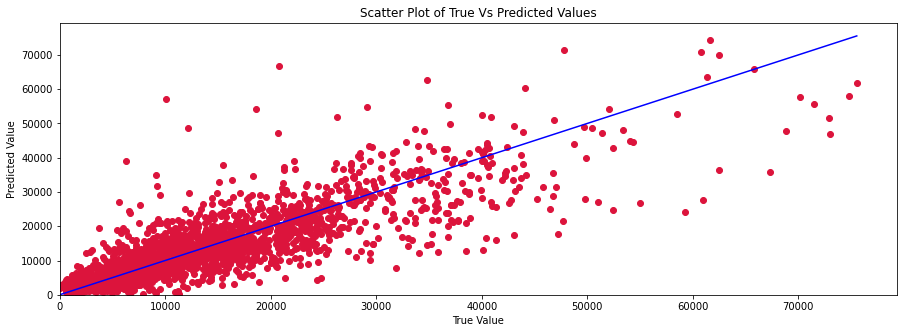

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[5], c='crimson')
p1 = max(max(Y_pred[5]), max(Y_test))
p2 = min(min(Y_pred[5]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

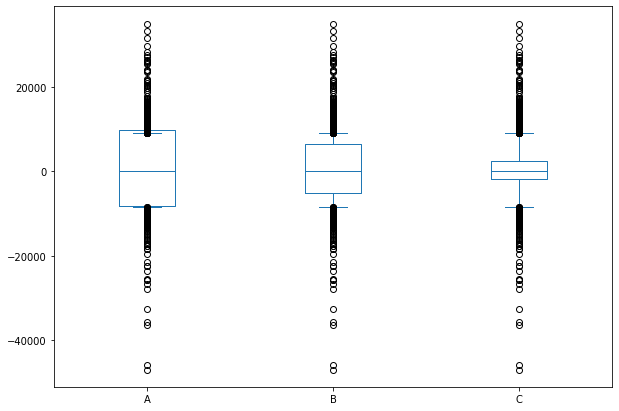

In [ ]:
import matplotlib.cbook as cbook
a=Y_test.subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))
#Mean absolute error : 2962.908538429619

Mean absolute error : 3758.2995451222764


In [ ]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)
#3.93573856288713e+16

0.39371446233162566


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)

In [ ]:
relative_absolute_error(Y_test, Y_pred)
#0.36881065009764674

0.45393190414380524

In [ ]:
Y_test

0        4656.0
1        5294.0
2        6627.0
3        9069.0
4       10859.0
         ...   
2437     8839.0
2438     9454.0
2439     9852.0
2440     8090.0
2441     6403.0
Name: DL_bitrate, Length: 2442, dtype: float64

In [ ]:
Y_pred=Y_pred[5]

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)

In [ ]:
rrse(Y_test, Y_pred)
#0.24690211285489344

0.3111142556228248

# Combination of Different Modes of Transportaion

In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv")  

In [ ]:
all_files_train=[]
all_files_test=[]

In [ ]:
bus_all_files.sort()
all_files_train = all_files_train + bus_all_files[:-3]
all_files_test = all_files_test + bus_all_files[-3:]

car_all_files.sort()
all_files_train = all_files_train + car_all_files[:-3]
all_files_test = all_files_test + car_all_files[-3:]

pedestrian_all_files.sort()
all_files_train = all_files_train + pedestrian_all_files[:-3]
all_files_test = all_files_test + pedestrian_all_files[-3:]

static_all_files.sort()
all_files_train = all_files_train + static_all_files[:-3]
all_files_test = all_files_test + static_all_files[-3:]

train_all_files.sort()
all_files_train = all_files_train + train_all_files[:-3]
all_files_test = all_files_test + train_all_files[-3:]

In [ ]:
# Train Dataset
li_train = []
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame_train = pd.concat(li_train, axis=0, ignore_index=True)
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame_train.shape

(157752, 46)

In [ ]:
# Test Dataset
li_test = []
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_test.append(df)
frame_test = pd.concat(li_test, axis=0, ignore_index=True)
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,12,11,12,11,11,46905,54253,63379,68557,68557,...,18.0,14.0,14.0,14.0,756,956,972,1026,1026,51399
1,10,12,11,12,11,52184,46905,54253,63379,68557,...,18.0,18.0,14.0,14.0,908,756,956,972,1026,49728
2,12,10,12,11,12,57262,52184,46905,54253,63379,...,16.0,18.0,18.0,14.0,828,908,756,956,972,46853
3,12,12,10,12,11,53862,57262,52184,46905,54253,...,16.0,16.0,18.0,18.0,894,828,908,756,956,43102
4,10,12,12,10,12,57407,53862,57262,52184,46905,...,16.0,16.0,16.0,18.0,1265,894,828,908,756,40899


In [ ]:
frame_test.shape

(15556, 46)

# Dealing with NaN Values

## Train Dataset

In [ ]:
frame_train.replace('-', np.NaN, inplace = True)
frame_train.isna().sum().sum()

1312040

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_train)
frame_train = pd.DataFrame(imputed_dataset,columns = frame_train.columns)
frame_train.isna().sum().sum()

0

In [ ]:
frame_train.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,...,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000,157752.000000
mean,7.641361,7.604101,7.622050,7.609666,7.622525,9724.774957,9727.105653,9729.016608,9731.364503,9733.521521,...,5.801120,5.590722,5.645884,5.740537,168.282424,168.315248,168.343666,168.375545,168.410226,9717.288402
std,2.538428,2.545001,2.541392,2.544898,2.543107,13042.591125,13047.331213,13050.458054,13054.515238,13058.493025,...,6.724060,6.679686,6.690202,6.718909,204.387774,204.453685,204.496334,204.546875,204.604983,12592.534743
min,-0.612255,1.000000,1.000000,1.000000,0.784134,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30.000000,-30.000000,-30.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.911007,6.892143,6.958526,6.906773,6.901422,1219.000000,1219.000000,1219.000000,1219.000000,1219.000000,...,2.000000,2.000000,2.000000,2.000000,28.000000,28.000000,28.000000,28.000000,28.000000,1417.000000
50%,7.120286,7.004964,7.062224,7.024500,7.068401,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,...,7.228530,6.652735,6.779590,6.975890,95.000000,95.000000,95.000000,95.000000,95.000000,4909.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,13141.000000,13141.000000,13152.000000,13152.000000,13152.000000,...,7.776193,7.142767,7.371773,7.885166,242.000000,242.000000,242.000000,242.000000,242.000000,13268.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,173016.000000,173016.000000,173016.000000,173016.000000,173016.000000,...,33.000000,33.000000,33.000000,33.641380,4178.000000,4178.000000,4178.000000,4178.000000,4178.000000,161878.000000


## Test Dataset

In [ ]:
frame_test.replace('-', np.NaN, inplace = True)
frame_test.isna().sum().sum()

100468

In [ ]:
imputed_dataset = imputer.fit_transform(frame_test)
frame_test = pd.DataFrame(imputed_dataset,columns = frame_test.columns)
frame_test.isna().sum().sum()
frame_test.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,15556.000000,15556.000000,15556.000000,15556.000000,15556.00000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,...,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000
mean,9.215056,9.180175,9.161461,9.130983,9.15669,21794.796542,21794.644639,21799.217344,21806.383968,21813.936745,...,8.089707,8.111215,8.095310,8.232082,349.132168,349.122204,349.173245,349.246207,349.330612,21799.575084
std,2.526213,2.517253,2.512943,2.508262,2.51245,19242.347498,19239.767335,19237.915139,19238.155274,19241.164971,...,7.085187,7.088205,7.082441,7.131404,295.886194,295.811237,295.728444,295.638133,295.647554,18400.133766
min,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-16.000000,-16.000000,-16.000000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.00000,7448.000000,7448.000000,7448.000000,7456.250000,7459.000000,...,3.000000,3.000000,3.000000,3.000000,134.000000,134.000000,134.000000,134.000000,134.000000,8158.500000
50%,9.000000,9.000000,9.000000,9.000000,9.00000,16479.500000,16501.500000,16512.500000,16518.500000,16529.000000,...,8.000000,8.000000,8.000000,8.000000,270.000000,270.000000,271.000000,271.000000,271.000000,16870.500000
75%,11.000000,11.000000,11.000000,11.000000,11.00000,30778.000000,30778.000000,30783.500000,30802.750000,30836.750000,...,12.000000,12.000000,12.000000,12.303084,497.000000,497.000000,497.000000,497.000000,497.000000,30558.000000
max,15.000000,15.000000,15.000000,15.000000,15.00000,108693.000000,108693.000000,108693.000000,108693.000000,108693.000000,...,28.000000,28.000000,28.000000,28.000000,3852.000000,3852.000000,3852.000000,3852.000000,3852.000000,101836.000000


In [ ]:
frame_test.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,15556.000000,15556.000000,15556.000000,15556.000000,15556.00000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,...,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000,15556.000000
mean,9.215056,9.180175,9.161461,9.130983,9.15669,21794.796542,21794.644639,21799.217344,21806.383968,21813.936745,...,8.089707,8.111215,8.095310,8.232082,349.132168,349.122204,349.173245,349.246207,349.330612,21799.575084
std,2.526213,2.517253,2.512943,2.508262,2.51245,19242.347498,19239.767335,19237.915139,19238.155274,19241.164971,...,7.085187,7.088205,7.082441,7.131404,295.886194,295.811237,295.728444,295.638133,295.647554,18400.133766
min,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-16.000000,-16.000000,-16.000000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.00000,7448.000000,7448.000000,7448.000000,7456.250000,7459.000000,...,3.000000,3.000000,3.000000,3.000000,134.000000,134.000000,134.000000,134.000000,134.000000,8158.500000
50%,9.000000,9.000000,9.000000,9.000000,9.00000,16479.500000,16501.500000,16512.500000,16518.500000,16529.000000,...,8.000000,8.000000,8.000000,8.000000,270.000000,270.000000,271.000000,271.000000,271.000000,16870.500000
75%,11.000000,11.000000,11.000000,11.000000,11.00000,30778.000000,30778.000000,30783.500000,30802.750000,30836.750000,...,12.000000,12.000000,12.000000,12.303084,497.000000,497.000000,497.000000,497.000000,497.000000,30558.000000
max,15.000000,15.000000,15.000000,15.000000,15.00000,108693.000000,108693.000000,108693.000000,108693.000000,108693.000000,...,28.000000,28.000000,28.000000,28.000000,3852.000000,3852.000000,3852.000000,3852.000000,3852.000000,101836.000000


# MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:5], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (110426, 5)
Validation set shape (47326, 5)


,0,1,2,3,4
83480,0.010092,0.006462,0.002196,0.001936,0.002196
116859,0.010404,0.008722,0.005427,0.005167,0.009433
81722,0.001809,0.001352,0.001422,0.001873,0.000387
111880,0.040008,0.035355,0.041366,0.041112,0.043175
88395,0.017900,0.034130,0.042984,0.024495,0.088425


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (110426, 5, 1)
Validation set shape (47326, 5, 1)


# Stacked LSTM

In [ ]:
# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# summary of the model  
model.summary()
# use early stop to avoid over-fiting 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 150)            91200     
                                                                 
 dropout (Dropout)           (None, 5, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 150)            180600    
                                                                 
 lstm_2 (LSTM)               (None, 5, 150)            180600    
                                                                 
 dropout_1 (Dropout)         (None, 5, 150)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

In [ ]:
lstm_train_pred_min_max_scaled = model.predict(X_train_min_max_scaler)
lstm_valid_pred_min_max_scaled = model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, lstm_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, lstm_valid_pred_min_max_scaled)))

Train rmse: 0.02953999719657393
Validation rmse: 0.029194255434319027


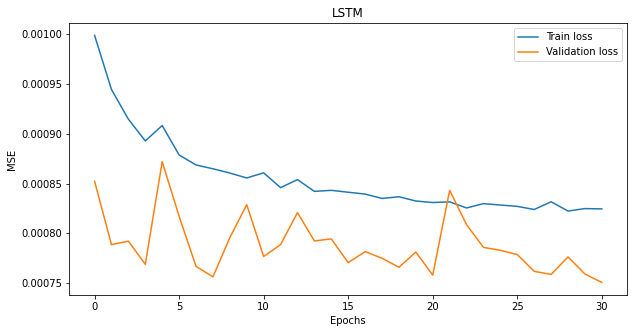

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(history.history['loss'], label='Train loss')
ax3.plot(history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')
plt.show()

In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_test_scaled = df_test_scaled.iloc[:,:5]
X_test_scaled.head()
Y_test = frame_test.iloc[:,-1:]
Y_test.head()
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
df_test_scaled.head()

,0,1,2,3,4,5
0,0.431537,0.499140,0.583101,0.630740,0.630740,0.457922
1,0.480105,0.431537,0.499140,0.583101,0.630740,0.447523
2,0.526823,0.480105,0.431537,0.499140,0.583101,0.461200
3,0.495542,0.526823,0.480105,0.431537,0.499140,0.461636
4,0.528157,0.495542,0.526823,0.480105,0.431537,0.473206


In [ ]:
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
df_test.head()
Y_pred = df_test.iloc[:,-1:]

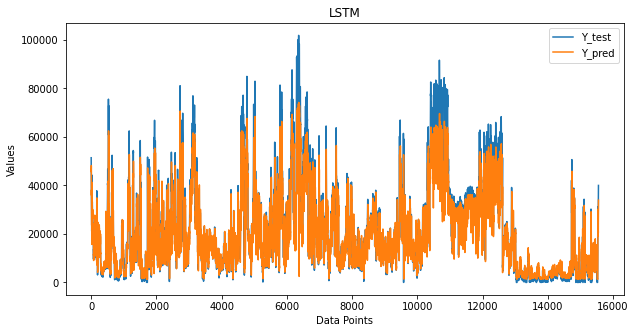

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

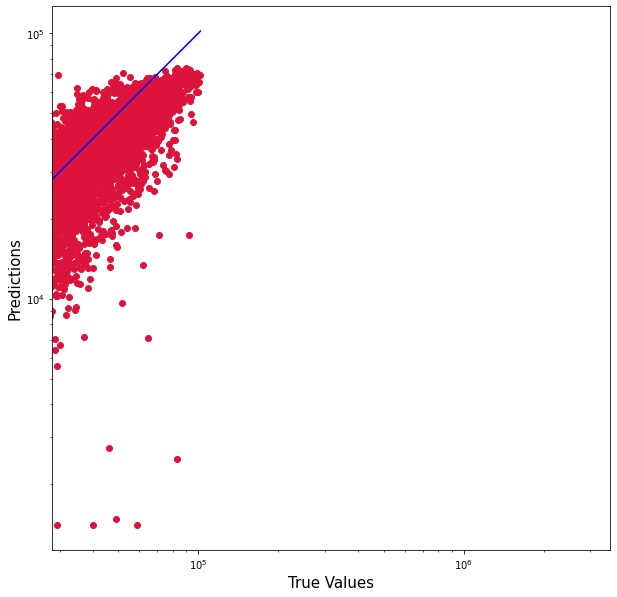

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test['DL_bitrate'], Y_pred[5], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred[5]), max(Y_test['DL_bitrate']))
p2 = min(min(Y_pred[5]), min(Y_test['DL_bitrate']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

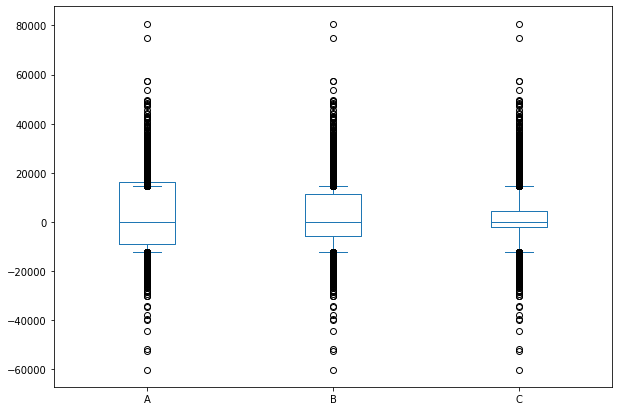

In [ ]:
a=Y_test['DL_bitrate'].subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 5276.2355021777885


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)
#0.3517153999832994

6.205320744023149e+16


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

# Hyperparameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=512, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=512, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=384, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 512)               3072      
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 384)               196992    
                                                                 
 dropout_5 (Dropout)         (None, 384)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
3451/3451 [==============================] - 10s 3ms/step - loss: 0.0150 - mean_absolute_error: 0.0150 - val_loss: 0.0151 - val_mean_absolute_error: 0.0151
Epoch 2/500
3451/3451 [==============================] - 9s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 3/500
3451/3451 [==============================] - 10s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0148 - val_mean_absolute_error: 0.0148
Epoch 4/500
3451/3451 [==============================] - 9s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 5/500
3451/3451 [==============================] - 9s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0147 - val_loss: 0.0146 - val_mean_absolute_error: 0.0146
Epoch 6/500
3451/3451 [==============================] - 9s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0146 - val_loss: 0.0145 - val_mean_absolute_error: 0.0

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.028397653206023183
Validation rmse: 0.027959761109724594


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4
0,0.431537,0.499140,0.583101,0.630740,0.630740
1,0.480105,0.431537,0.499140,0.583101,0.630740
2,0.526823,0.480105,0.431537,0.499140,0.583101
3,0.495542,0.526823,0.480105,0.431537,0.499140
4,0.528157,0.495542,0.526823,0.480105,0.431537


In [ ]:
Y_test = frame_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[5]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

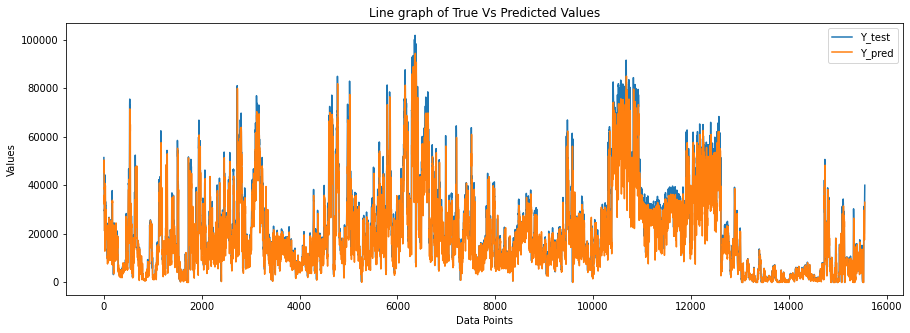

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

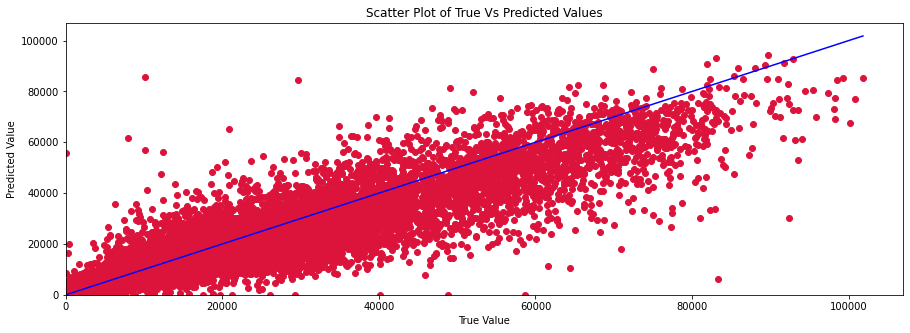

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[5], c='crimson')
p1 = max(max(Y_pred[5]), max(Y_test))
p2 = min(min(Y_pred[5]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

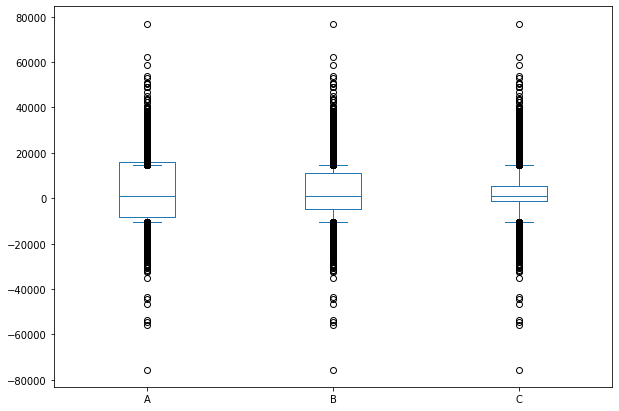

In [ ]:
a=Y_test.subtract(Y_pred[5])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_test

0        51399.0
1        49728.0
2        46853.0
3        43102.0
4        40899.0
          ...   
15551    35336.0
15552    36745.0
15553    38188.0
15554    39011.0
15555    39987.0
Name: DL_bitrate, Length: 15556, dtype: float64

In [ ]:
Y_pred= Y_pred[5]

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(5166.38671875, shape=(), dtype=float64)


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.3855704122126295

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.22615858334601505